In [1]:
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib widget
from datetime import date, datetime
from datetime import timedelta  
import json
from xgrads import open_CtlDataset

import geopandas as gpd
import rioxarray
import rasterio
import requests
from rasterio.features import shapes
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
from rasterio.features import rasterize
import scipy.ndimage as ndi
from dateutil.relativedelta import relativedelta


In [2]:
# domain
domain = 'BRIS'

# Path to the SnowModel folder
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
#datapath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/model_runs/'
#gagepath = '/nfs/attic/dfh/2020_NPRB/data/stream_gage/'+domain+'/'
topo_veg_ctl = SMpath+'topo_vege/dem_veg_'+domain+'.ctl'
disc_ctl = SMpath+'hydroflowcal1/disc_s30_f4.ctl'
wsd_ctl = SMpath+'/watershed/watershed.ctl'
dir_ctl = SMpath+'direction/dir.ctl'
wsdlistpath = '/nfs/attic/dfh/2020_NPRB/data/hf/'+domain+'/watersheds.csv'
#coastpath = '/nfs/attic/dfh/2020_NPRB/data/hf/'+domain+'/coast.nc'
coastmaskpath = '/nfs/attic/dfh/2020_NPRB/data/hf/'+domain+'/coast_mask.nc'



#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

st_dt = '2011-10-01'
STdt = datetime.strftime((datetime.strptime(st_dt,'%Y-%m-%d')+relativedelta(years=1)),'%Y-%m-%d')
ed_dt = '2018-09-30'

clsz = domains[domain]['cellsize']

In [3]:
# open landcover data
ctlFile = topo_veg_ctl

tv = open_CtlDataset(ctlFile)
tv

<xarray.Dataset>
Dimensions:  (time: 1, lat: 1228, lon: 949)
Coordinates:
  * time     (time) datetime64[ns] 2001-09-01
  * lat      (lat) float32 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * lon      (lon) float32 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
Data variables:
    topo     (time, lat, lon) float32 dask.array<chunksize=(1, 1228, 949), meta=np.ndarray>
    veg      (time, lat, lon) float32 dask.array<chunksize=(1, 1228, 949), meta=np.ndarray>
Attributes:
    comment:  topo
    storage:  0
    title:    xxxxxxxxxxxxxxxxxxxxxxxxx
    undef:    -9999.0
    pdef:     None

In [4]:
# open discharge data
q = open_CtlDataset(disc_ctl)
totq = q.slow.sum(dim='time')+q.fast.sum(dim='time')

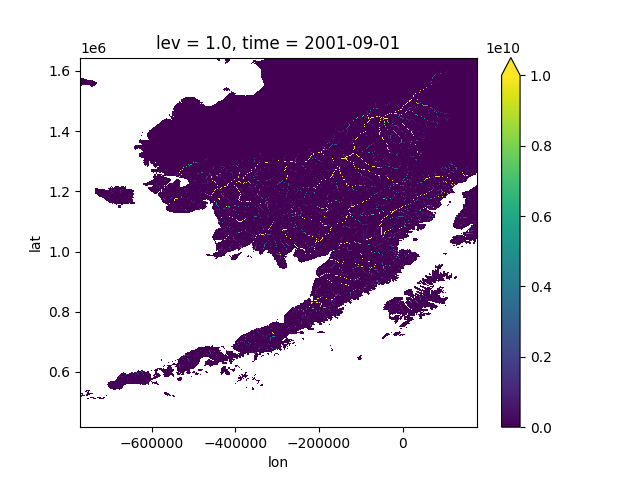

In [5]:
plt.figure()
totq.where(tv.veg!=24).plot(vmin=0,vmax=1e10)

In [6]:
# open watershed data
wd = open_CtlDataset(wsd_ctl)
wd

<xarray.Dataset>
Dimensions:  (time: 1, lev: 1, lat: 1228, lon: 949)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01
  * lev      (lev) float64 1.0
  * lat      (lat) float32 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * lon      (lon) float32 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
Data variables:
    dir      (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
    wshed    (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
    order    (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
Attributes:
    comment:  flow direction
    storage:  0
    title:    
    undef:    -9999.0
    pdef:     None

In [7]:
# open list of watersheds to include
wsd_list = pd.read_csv(wsdlistpath,index_col=0)
wsdlist=wsd_list.wd.tolist()

In [11]:
len(wsdlist)

3791

In [8]:
# function to determine the index to the direction of flow for any pixel of interest
def getflowidx(yindex, xindex, code):
    if code == 1:
        youtdex = yindex+1
        xoutdex = xindex+1
    elif code == 2:
        youtdex = yindex
        xoutdex = xindex+1
    elif code == 4:
        youtdex = yindex-1
        xoutdex = xindex+1
    elif code == 8:
        youtdex = yindex
        xoutdex = xindex-1
    elif code == 16:
        youtdex = yindex-1
        xoutdex = xindex-1
    elif code == 32:
        youtdex = yindex-1
        xoutdex = xindex
    elif code == 64:
        youtdex = yindex+1
        xoutdex = xindex-1
    elif code == 128:
        youtdex = yindex+1
        xoutdex = xindex
    else:
        print('invalid direction')

    return youtdex, xoutdex

In [9]:
# for each watershed - get the pixel id with the highest cumulative flow
qs = []
As = []
pplatidxs = []
pplonidxs = []
fcodes = []
flatidxs = []
flonidxs = []
fqs = []
flcs = []
fwss = []

WSHED = wd.wshed.isel(time=0,lev=0).values
TOTQ = totq.isel(lev=0).values
DIR = wd.dir.isel(time=0,lev=0).values
TV = tv.veg.isel(time=0).values

for wds in wsdlist:
    
    qslice = np.where(WSHED==wds,TOTQ,np.nan)
    qs.append(np.nanmax(qslice))
    As.append(sum(~np.isnan(np.where(WSHED==wds,TOTQ,np.nan).flatten()))*int(clsz)*int(clsz))
    idx = np.argwhere(qslice==np.nanmax(qslice))
    ydex = idx[0][0]
    xdex = idx[0][1]
    pplatidxs.append(ydex)
    pplonidxs.append(xdex)
    fcode = DIR[ydex,xdex]
    fcodes.append(fcode)
    if fcode ==0:
        flatidxs.append(np.nan)
        flonidxs.append(np.nan)
        fqs.append(np.nan)
    else:
        # get index to check for ocean at end of flow path
        youtdex, xoutdex = getflowidx(ydex, xdex, fcode)
        flatidxs.append(youtdex)
        flonidxs.append(xoutdex)
        fqs.append(TOTQ[youtdex,xoutdex])
    flcs.append(TV[youtdex,xoutdex])
    fwss.append(WSHED[youtdex,xoutdex])

In [10]:
df = pd.DataFrame(data={'wshedid':wsdlist,'Qtot':qs,'area':As,'latidx':pplatidxs,'lonidx':pplonidxs,'fcode':fcodes,'flatidx':flatidxs,'flonidx':flonidxs,'fq':fqs,'flc':flcs,'fws':fwss})
df

,wshedid,Qtot,area,latidx,lonidx,fcode,flatidx,flonidx,fq,flc,fws
0,870.0,22486810.0,8000000,177,84,128.0,178,84,-5.047758e+13,24.0,870.0
1,871.0,28525992.0,11000000,177,86,64.0,178,85,-5.047756e+13,24.0,871.0
2,872.0,53916524.0,17000000,177,87,128.0,178,87,-5.047754e+13,24.0,872.0
3,873.0,5761306.0,3000000,177,88,128.0,178,88,-5.047759e+13,24.0,873.0
4,875.0,66105356.0,24000000,177,91,128.0,178,91,-5.047753e+13,24.0,875.0
...,...,...,...,...,...,...,...,...,...,...,...
1097,3225.0,13624982.0,9000000,409,448,1.0,410,449,-5.047758e+13,24.0,3225.0
1098,3226.0,4541667.0,3000000,410,443,1.0,411,444,-5.047759e+13,24.0,3226.0
1099,3227.0,6798714.5,4000000,411,446,128.0,412,446,-5.047759e+13,24.0,3227.0
1100,3228.0,4516984.0,3000000,411,448,128.0,412,448,-5.047759e+13,24.0,3228.0


In [11]:
df.to_csv('coast_id_stats_'+domain+'.csv')

# water balance

In [8]:
c = pd.read_csv('coast_id_stats_'+domain+'.csv',index_col=0)
c

,wshedid,Qtot,area,latidx,lonidx,fcode,flatidx,flonidx,fq,flc,fws
0,704.0,25435208.0,3000000,125,80,8.0,125,79,0.0,19.0,717.0
1,705.0,162355740.0,14000000,125,81,8.0,125,80,25435208.0,19.0,704.0
2,706.0,167978460.0,14000000,125,82,8.0,125,81,162355740.0,9.0,705.0
3,707.0,17299916.0,2000000,125,83,8.0,125,82,167978460.0,9.0,706.0
4,708.0,17372022.0,2000000,125,84,8.0,125,83,17299916.0,6.0,707.0
...,...,...,...,...,...,...,...,...,...,...,...
3786,8979.0,10681301.0,2000000,851,170,32.0,850,170,10710608.0,19.0,8978.0
3787,8980.0,42881050.0,8000000,852,170,32.0,851,170,10681301.0,9.0,8979.0
3788,8981.0,0.0,2000000,853,170,32.0,852,170,42881050.0,12.0,8980.0
3789,8982.0,10660840.0,2000000,854,170,32.0,853,170,0.0,9.0,8981.0


In [9]:
# watersheds that flow into the ocean
len(c.loc[c.flc==24])

2250

In [10]:
#watershed that flow to different watersheds with lower max discharge
df1 = c.loc[(c.fws!=c.wshedid)&(c.Qtot>c.fq)].reset_index(drop=True)
fws = df1.fws.tolist()

fwsa = []
for ws in fws:
    try:
        if (ws == 0):
            fwsa.append(0)
        else:
            fwsa.append(int(c.area.loc[c.wshedid==ws]))
    except:
        fwsa.append(np.nan)
df1['fwsarea']=fwsa

# want to keep nan places because these flow to watersheds not in the watershed list
df2 = df1.loc[np.isnan(df1.fwsarea)]
df3 = df1.loc[~np.isnan(df1.fwsarea)]
df4 = df3.loc[df3.area<df3.fwsarea]
drop_list = df4.wshedid.tolist()
df5 = c.loc[~c.wshedid.isin(drop_list)]
df6 = df5.loc[df5.Qtot>0]
df6

,wshedid,Qtot,area,latidx,lonidx,fcode,flatidx,flonidx,fq,flc,fws
1,705.0,162355740.0,14000000,125,81,8.0,125,80,25435208.0,19.0,704.0
2,706.0,167978460.0,14000000,125,82,8.0,125,81,162355740.0,9.0,705.0
3,707.0,17299916.0,2000000,125,83,8.0,125,82,167978460.0,9.0,706.0
4,708.0,17372022.0,2000000,125,84,8.0,125,83,17299916.0,6.0,707.0
7,715.0,254767840.0,21000000,126,76,8.0,126,75,16579987.0,9.0,729.0
...,...,...,...,...,...,...,...,...,...,...,...
3785,8978.0,16058784.0,4000000,851,171,16.0,850,170,10710608.0,19.0,8978.0
3786,8979.0,10681301.0,2000000,851,170,32.0,850,170,10710608.0,19.0,8978.0
3787,8980.0,42881050.0,8000000,852,170,32.0,851,170,10681301.0,9.0,8979.0
3789,8982.0,10660840.0,2000000,854,170,32.0,853,170,0.0,9.0,8981.0


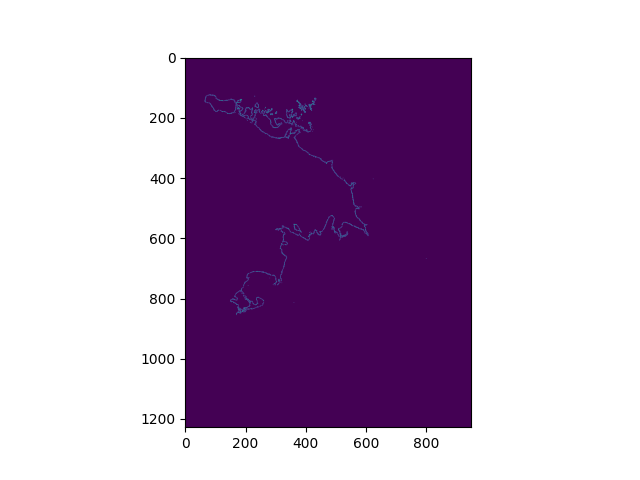

In [11]:
dfc = df6.reset_index(drop=True)
maskq = np.zeros([len(tv.lat),len(tv.lon)])
for i in range(len(dfc)):
    maskq[dfc.latidx[i],dfc.lonidx[i]]=1
plt.figure()
plt.imshow(maskq)
# add mask to ds
tv["maskq"]=(['lat', 'lon'],  maskq)

In [12]:
#save coast mask to .nc file
tv.maskq.to_netcdf(coastmaskpath)

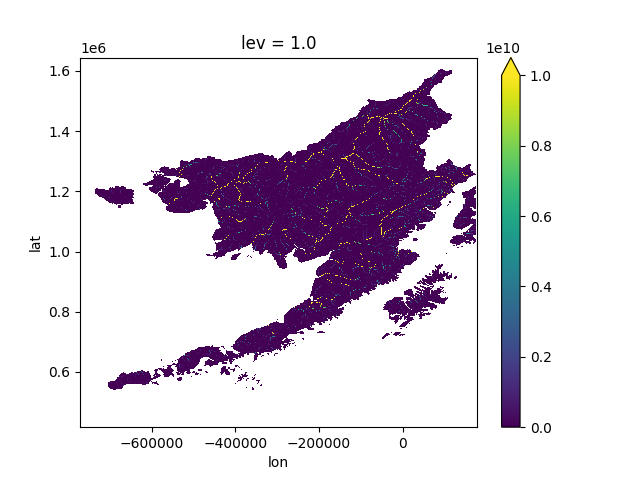

In [16]:
plt.figure()
totq.where(totq>0).plot(vmin=0,vmax=1e10)

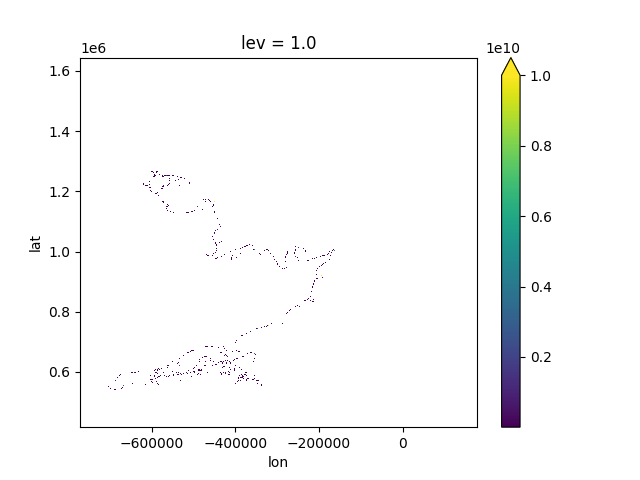

In [17]:
plt.figure()
totq.where(tv.maskq==1).plot(vmax=1e10)

In [18]:
# #import rioxarray as rxr
# tq = totq.isel(lev=0)
# tq = totq.rename({'lon': 'x','lat': 'y'})
# tq.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
# tq.rio.to_raster("total_q.tif")
# tq

In [19]:
prec_ctl = SMpath+'ctl_files/wo_assim/prec_cal.ctl'
ssub_ctl = SMpath+'ctl_files/wo_assim/ssub_cal.ctl'
rfctlout = SMpath+'ctl_files/wo_assim/roff_cal.ctl'
rfxctlout = SMpath+'ctl_files/wo_assim/rofx_cal.ctl'
swectlout = SMpath+'ctl_files/wo_assim/swed_cal.ctl'
etxctlout = SMpath+'ctl_files/wo_assim/etx_cal.ctl'

In [20]:
# precipitation

p = open_CtlDataset(prec_ctl)
p

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 1228, lon: 949)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * lon      (lon) float32 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
Data variables:
    prec     (time, lat, lon) float32 dask.array<chunksize=(1, 1228, 949), meta=np.ndarray>
Attributes:
    comment:  water-equivalent precipitation
    storage:  0
    title:    SnowModel
    undef:    -9999.0
    pdef:     None

In [21]:
# open sublimation data
sub = open_CtlDataset(ssub_ctl)
sub

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 1228, lon: 949)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * lon      (lon) float32 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
Data variables:
    ssub     (time, lat, lon) float32 dask.array<chunksize=(1, 1228, 949), meta=np.ndarray>
Attributes:
    comment:  static-surface sublimation
    storage:  0
    title:    SnowModel
    undef:    -9999.0
    pdef:     None

In [22]:
# open roff data

rf = open_CtlDataset(rfctlout)
rf

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 1228, lon: 949)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * lon      (lon) float32 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
Data variables:
    roff     (time, lat, lon) float32 dask.array<chunksize=(1, 1228, 949), meta=np.ndarray>
Attributes:
    comment:  runoff from snowpack base
    storage:  0
    title:    SnowModel
    undef:    -9999.0
    pdef:     None

In [23]:
# open rofx data
rfx = open_CtlDataset(rfxctlout)
rfx

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 1228, lon: 949)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * lon      (lon) float32 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
Data variables:
    roff     (time, lat, lon) float32 dask.array<chunksize=(1, 1228, 949), meta=np.ndarray>
Attributes:
    comment:  runoff from snowpack base
    storage:  0
    title:    
    undef:    -9999.0
    pdef:     None

In [24]:
# open swed data

swe = open_CtlDataset(swectlout)
swe

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 1228, lon: 949)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * lon      (lon) float32 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
Data variables:
    swed     (time, lat, lon) float32 dask.array<chunksize=(1, 1228, 949), meta=np.ndarray>
Attributes:
    comment:  snow-water-equivalent depth
    storage:  0
    title:    SnowModel
    undef:    -9999.0
    pdef:     None

In [25]:
# open et data

et = open_CtlDataset(etxctlout)
et

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 1228, lon: 949)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * lon      (lon) float32 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
Data variables:
    etx      (time, lat, lon) float32 dask.array<chunksize=(1, 1228, 949), meta=np.ndarray>
Attributes:
    comment:  evapotranspiration
    storage:  0
    title:    
    undef:    -9999.0
    pdef:     None

In [26]:
# watershed area only including pixels with modeling output
h2oshed_area = int(wd.wshed.where(wd.wshed.isin(wsdlist)).count())*int(clsz)*int(clsz)
# number of pixels in watershed
h2oshed_num = int(wd.wshed.where(wd.wshed.isin(wsdlist)).count())
h2oshed_area,h2oshed_num

(279852000000, 279852)

In [27]:
start_years_list = list(range(int(st_dt[:4]),int(ed_dt[:4])))
end_years_list = list(range(int(st_dt[:4])+1,int(ed_dt[:4])+1))

specQs = []
specPs = []
specETs = []
specSUBs = []
specSWEs = []
specSWEclrs = []
specRFs = []
specRFXs = []

for y in range(len(start_years_list)):
    styr = start_years_list[y]
    edyr = end_years_list[y]
    print(styr,edyr)
    # Q
    Q = q.sel(time=slice(str(styr)+'-10-01',str(edyr)+'-09-30'))
    TOTQ = Q.slow.sum(dim='time')+Q.fast.sum(dim='time')
    QQ = TOTQ.where(tv.maskq==1)
    specQ = int(QQ.sum())/h2oshed_area
    specQs.append(specQ)  
    # P
    P = p.sel(time=slice(str(styr)+'-10-01',str(edyr)+'-09-30'))
    ptot = P.prec.sum(dim='time')
    pslice = ptot.where((ptot>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))   
    specP = int(pslice.sum())/h2oshed_num
    specPs.append(specP)
    #ET
    ET = et.sel(time=slice(str(styr)+'-10-01',str(edyr)+'-09-30'))
    ettot = ET.etx.sum(dim='time')
    etslice = ettot.where((ettot>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))    
    specET = int(etslice.sum())/h2oshed_num
    specETs.append(specET)
    # SUB
    SUB = sub.sel(time=slice(str(styr)+'-10-01',str(edyr)+'-09-30'))
    subtot = SUB.ssub.sum(dim='time')
    subslice = subtot.where((subtot>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))    
    specSUB = int(subslice.sum())/h2oshed_num
    specSUBs.append(specSUB)
    #SWE
    sweend = swe.swed.sel(time=str(edyr)+'-09-30')
    swesum = sweend.where((sweend>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist))).sum()
    swecount = sweend.where((sweend>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist))).count()
    specSWE = swesum.values/swecount.values
    specSWEs.append(specSWE)
    #SWE cleared
    swend = swe.swed.sel(time=str(edyr)+'-08-31')
    swsum = swend.where((swend>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist))).sum()
    swcount = swend.where((swend>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist))).count()
    specSWEclr = swsum.values/swcount.values
    specSWEclrs.append(specSWEclr)
    #ROFF
    RF = rf.sel(time=slice(str(styr)+'-10-01',str(edyr)+'-09-30'))
    rftot = RF.roff.sum(dim='time')
    rfslice = rftot.where((rftot>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))    
    specRF = int(rfslice.sum())/h2oshed_num
    specRFs.append(specRF)
    #ROFX
    RFX = rfx.sel(time=slice(str(styr)+'-10-01',str(edyr)+'-09-30'))
    rfxtot = RFX.roff.sum(dim='time')
    rfxslice = rfxtot.where((rftot>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))    
    specRFX = int(rfxslice.sum())/h2oshed_num
    specRFXs.append(specRFX)    

2011 2012
2012 2013
2013 2014
2014 2015
2015 2016
2016 2017
2017 2018


In [28]:
dat={'P':specPs,'Q':specQs,'ET':specETs,'SUB':specSUBs,'SWE':specSWEs,'RF':specRFs,'RFX':specRFXs}
idx = end_years_list
df = pd.DataFrame(data = dat,index=idx)
#df['RFdif'] = df.RF-df.RFX
df['TOTwater_balQ'] = df.P-(df.Q+df.ET+df.SUB+df.SWE)
df['TOTmissing_fracQ'] = df.TOTwater_balQ/df.P
df['SMwater_bal'] = df.P-(df.SUB+df.SWE+df.RF)
df['HFwater_balQ'] = df.RFX-df.Q
df['HFmissing_fracQ'] = df.HFwater_balQ/df.RFX
df['RFXwater_bal'] = df.RF-(df.RFX+df.ET)
df

,P,Q,ET,SUB,SWE,RF,RFX,TOTwater_balQ,TOTmissing_fracQ,SMwater_bal,HFwater_balQ,HFmissing_fracQ,RFXwater_bal
2012,1.001790,0.587346,0.238658,0.008751,0.020904,0.953815,0.715153,0.146131,0.145870,0.018320,0.127807,0.178713,3.573317e-06
2013,0.804318,0.581860,0.202886,0.012742,0.013472,0.774363,0.571477,-0.006642,-0.008258,0.003740,-0.010383,-0.018168,-1.110223e-16
2014,0.954680,0.679024,0.213356,0.006925,0.013738,0.938085,0.724726,0.041637,0.043614,-0.004068,0.045702,0.063061,3.573317e-06
2015,0.969584,0.633028,0.226377,0.009498,0.035243,0.931818,0.705441,0.065438,0.067491,-0.006974,0.072413,0.102649,0.000000e+00
2016,1.113732,0.793578,0.257032,0.006035,0.090063,1.102165,0.845132,-0.032977,-0.029609,-0.084531,0.051554,0.061001,0.000000e+00
2017,0.826079,0.554556,0.227820,0.006171,0.044298,0.807255,0.579435,-0.006766,-0.008191,-0.031645,0.024879,0.042936,0.000000e+00
2018,1.102158,0.779419,0.254016,0.007618,0.058909,1.079428,0.825411,0.002195,0.001992,-0.043797,0.045992,0.055720,0.000000e+00


In [29]:
df.to_csv(domain+'_cal_H2Obudget_table.csv')

In [30]:
#Q = q.sel(time=slice(STdt,ed_dt))
Q=q
Q = Q.sel(time=slice('2012-10-01','2018-09-30'))
TOTQ = Q.slow.sum(dim='time')+Q.fast.sum(dim='time')
QQ = TOTQ.where(tv.maskq==1)
specQ = int(QQ.sum())/h2oshed_area
print('Average annual coastal runoff = ',QQ.sum().values.tolist()/6, 'cubic meters/year')
print('Average annual specific  runoff = ',specQ/6, 'meters/year')

Average annual coastal runoff =  187569209344.0 cubic meters/year
Average annual specific  runoff =  0.6702443053614053 meters/year


Text(0.5, 1.0, 'BRIS calibration')

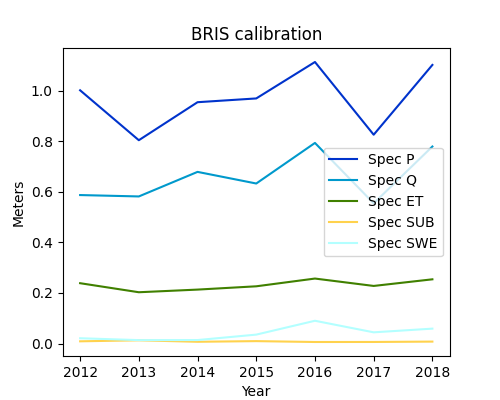

In [31]:
plt.figure(figsize = [5,4])
plt.plot(df.index,df.P,label='Spec P',c='#0033cc')
plt.plot(df.index,df.Q,label='Spec Q',c='#0099cc')
plt.plot(df.index,df.ET,label='Spec ET',c='#408000')
plt.plot(df.index,df.SUB,label='Spec SUB',c='#ffd24d')
plt.plot(df.index,df.SWE,label='Spec SWE',c='#b3ffff')
plt.xlabel('Year')
plt.ylabel('Meters')
plt.legend()
plt.title(domain+' calibration')

In [32]:
plt.savefig(domain+'cal_waterbudg.png',dpi=300)